# Prepare Cluster-by-Gene mC Profile

This notebook sum cell feature counts in a cell MCDS by cell clusters. The cluster MCDS can be transform and saved as RegionDS

In [1]:
import pandas as pd
from ALLCools.mcds import MCDS
from ALLCools.clustering import cluster_enriched_features

## Merge Cluster

In [2]:
mc_cluster = pd.read_csv(
    '../../data/HIPBulk/DesideBulkLevel/snmC.anno.csv',
    header=None,
    index_col=0,
    squeeze=True)

m3c_cluster = pd.read_csv(
    '../../data/HIPBulk/DesideBulkLevel/snm3C.anno.csv',
    header=None,
    index_col=0,
    squeeze=True)

mc_cluster = 'snmC_' + mc_cluster
m3c_cluster = 'snm3C_' + m3c_cluster
cell_cluster = pd.concat([mc_cluster, m3c_cluster])
cell_cluster.index.name = 'cell'
cell_cluster.name = 'sample'

In [3]:
mcds = MCDS.open('../../data/Brain/snm*C-seq*/*.mcds')

Open MCDS with netcdf4 engine.


In [4]:
mcds.coords['sample'] = cell_cluster

In [5]:
cluster_mcds = mcds.merge_cluster(cluster_col='sample').to_region_ds('geneslop2k')

In [6]:
cluster_mcds

<xarray.RegionDS>
Dimensions:              (mc_type: 2, count_type: 2, geneslop2k: 55487, sample: 20, chrom100k: 27269)
Coordinates: (12/14)
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
  * geneslop2k           (geneslop2k) object 'ENSMUSG00000102693.1' ... 'ENSM...
    geneslop2k_chrom     (geneslop2k) object 'chr1' 'chr1' ... 'chrM' 'chrM'
    geneslop2k_start     (geneslop2k) int64 3071252 3100015 ... 13288 13355
    ...                   ...
    sample_CGN           (sample) float64 0.7203 0.7387 0.7422 ... 0.7434 0.7196
    sample_CHN           (sample) float64 0.007835 0.02362 ... 0.01121 0.005743
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object 'chr1' 'chr1' ... 'chrY' 'chrM'
    chrom100k_bin_start  (chrom100k) int64 0 100000 200000 ... 91700000 0
    chrom100k_bin_end    (chrom100k) int64 100000 200000 ... 91744698 16299
Data variables:
    geneslop2k_da        (sample, geneslop2k, mc_type, count_type) float64 1....
    chrom100k_da         (sample, chrom100k, mc_type, count_type) float64 0.0...
    geneslop2k_da_frac   (sample, geneslop2k, mc_type) float64 1.252 ... 4.546
    chrom100k_da_frac    (sample, chrom100k, mc_type) float64 1.0 1.0 ... 5.264
Attributes:
    region_dim:  geneslop2k

In [7]:
cluster_mcds.to_zarr('test_HIP_Cluster')

## Cluster Enrichment

In [8]:
mcds.add_mc_frac(var_dim='geneslop2k')

In [9]:
adata = mcds.get_adata(mc_type='CHN',
                       var_dim='geneslop2k',
                       da_suffix='frac',
                       obs_dim='cell',
                       select_hvf=False)

/home/hanliu/miniconda3/envs/allcools_new/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hanliu/miniconda3/envs/allcools_new/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hanliu/miniconda3/envs/allcools_new/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [10]:
adata.obs['cluster'] = adata.obs['sample'].str.split('_').str[1]

cell_ids = adata.obs.groupby('cluster').apply(lambda i: i if i.shape[
    0] < 1500 else i.sample(1500)).index.get_level_values(1)
adata = adata[cell_ids, :]

Found 10 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
Trying to set attribute `._uns` of view, copying.


Selected 1653 unique features


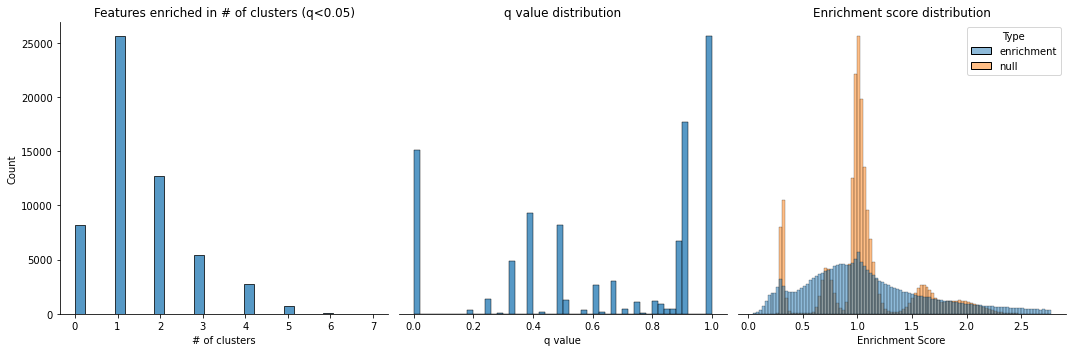

In [11]:
cluster_enriched_features(adata,
                          cluster_col='cluster',
                          top_n=200,
                          alpha=0.05,
                          stat_plot=True,
                          method='mc')

In [12]:
qvals = pd.DataFrame(
    adata.uns['cluster_feature_enrichment']['qvals'],
    index=adata.var_names,
    columns=adata.uns['cluster_feature_enrichment']
    ['cluster_order'])

qvals.to_hdf('mCH.cluster_enrichment_qvals.hdf', key='data')